Alzheimer's Classification Problem

The dataset used in this problem can be found here: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images?resource=download

The goal of this project is to train a classification model to correctly determine if an alzheimer scan is from a brain as
   1. Non Demented
   2. Mild Demented
   3. Moderate Demented
   4. Very Mild Demented

A decision tree classifier will be trained on the provided training images. This classifier will be scored on accuracy, and then an Adaboost and Random Forest will be used to see if greater accuracy can be achieved.

For information on how to process images in python, this article offered a great overview: https://www.analyticsvidhya.com/blog/2014/12/image-processing-python-basics/


First, the libraries used will be imported.

In [158]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from skimage import exposure
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.io import imread
from skimage.color import rgb2gray
import glob
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

Exploratory Data Analysis

Process an image to see how the data looks. This is an example of a non-demented brain scan.

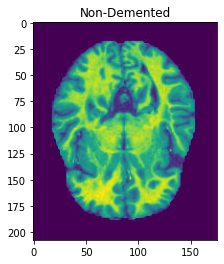

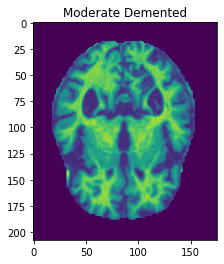

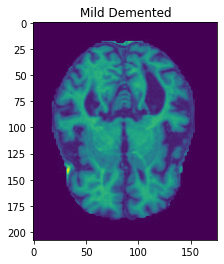

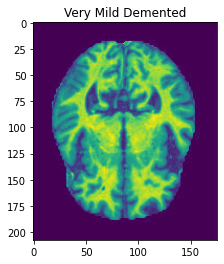

In [73]:
nonDem = imread('./Alzheimer_Train/NonDemented/nonDem0.jpg')
modDem = imread('./Alzheimer_Train/ModerateDemented/moderateDem0.jpg')
mildDem = imread('./Alzheimer_Train/MildDemented/mildDem0.jpg')
vmildDem = imread('./Alzheimer_Train/VeryMildDemented/verymildDem1.jpg')
plt.imshow(nonDem)
plt.title("Non-Demented")
plt.show()
plt.imshow(modDem)
plt.title("Moderate Demented")
plt.show()
plt.imshow(mildDem)
plt.title("Mild Demented")
plt.show()
plt.imshow(vmildDem)
plt.title("Very Mild Demented")
plt.show()

Using the Laplacian of Gaussian strategy through functions in skimage, patterns will be recognized in the picture.

Information gathered from: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html#sphx-glr-auto-examples-features-detection-plot-blob-py

Laplacian of Gaussian (LoG)
This is the most accurate and slowest approach. It computes the Laplacian of Gaussian images with successively increasing standard deviation and stacks them up in a cube. Blobs are local maximas in this cube. Detecting larger blobs is especially slower because of larger kernel sizes during convolution. Only bright blobs on dark backgrounds are detected

[[ 46.         133.           3.22222222]
 [149.          93.           1.        ]
 [ 73.         110.           2.77777778]
 [118.          31.           4.11111111]
 [ 65.         125.           4.55555556]
 [178.          80.           3.22222222]
 [ 80.         102.           2.33333333]
 [178.         101.           5.        ]
 [148.          80.           4.11111111]
 [109.          36.           2.77777778]
 [118.         141.           4.55555556]
 [147.         136.           3.22222222]
 [ 84.          68.           2.33333333]
 [ 37.         116.           5.        ]
 [ 25.          97.           5.        ]
 [167.         115.           5.        ]
 [101.          41.           2.33333333]
 [153.         125.           4.11111111]
 [ 34.          56.           5.        ]
 [122.         131.           1.        ]
 [166.          51.           5.        ]
 [ 72.          40.           5.        ]
 [ 62.          99.           3.22222222]
 [ 48.          41.           3.22

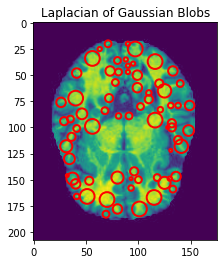

In [104]:
# get Laplacian of Gaussian calculations
img = exposure.equalize_hist(nonDem)
blobs = blob_log(img, max_sigma=5, threshold=0.1)
print(blobs)

# compute radius of blob
blobs[:,2] = blobs[:,2]*np.sqrt(2)

# plot
fig, ax = plt.subplots()
ax.set_title('Laplacian of Gaussian Blobs')
ax.imshow(nonDem)
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x,y), r, color="red", linewidth=2, fill = False)
    ax.add_patch(c)
plt.show()

The format shown above is capable of being used in a sklearn model. It seems that setting the sigma level to 15 and threshold to .15 give the best results. In a further study, a parameter optimisation could be run on these values.

Building the Dataset

The images provided in the kaggle dataset are not formatted perfectly for machine learning. In this section, the training and test datasets will be built. Even though the dataset gives four categories, this project will focus on only Demented or Non-Demented for diagnoses capability.

The x-axis will contain the images processed through the LoG function, and the y-axis will contain the following labels:
    0 = Non-Demented
    1 = Moderate Demented
    2 = Mild Demented
    3 = Very Mild Demented

This takes a very long time.

In [146]:
train_directories = ['./Alzheimer_Train/NonDemented', './Alzheimer_Train/ModerateDemented', './Alzheimer_Train/MildDemented', './Alzheimer_Train/VeryMildDemented']
test_directories = ['./Alzheimer_Test/NonDemented', './Alzheimer_Test/ModerateDemented', './Alzheimer_Test/MildDemented', './Alzheimer_Test/VeryMildDemented']

# Build Training Set
x_train = []
y_train = []

first_check = True
for category in train_directories:
    for image in os.listdir(category):
        if first_check:
            img = imread(category+'\\'+image)
            img = exposure.equalize_hist(img)
            x_train.append(len(blob_log(img, max_sigma=15, threshold=0.085))) # gets number of blobs found
            y_train.append(0)
        else:
            img = imread(category+'\\'+image)
            img = exposure.equalize_hist(img)
            x_train.append(len(blob_log(img, max_sigma=15, threshold=0.085))) # gets number of blobs found
            y_train.append(1)
    first_check = False

# Build Test Set
x_test = [] # training images processed through LoG
y_test = [] # labels

first_check = True
for category in test_directories:
    for image in os.listdir(category):
        if first_check:
            img = imread(category+'\\'+image)
            img = exposure.equalize_hist(img)
            x_test.append(len(blob_log(img, max_sigma=15, threshold=0.085))) # gets number of blobs found
            y_test.append(0)
        else:
            img = imread(category+'\\'+image)
            img = exposure.equalize_hist(img)
            x_test.append(len(blob_log(img, max_sigma=15, threshold=0.085))) # gets number of blobs found
            y_test.append(1)
    first_check = False

Now, the machine learning begins! A Decision Tree Classifier will be fit to the built dataset. The accuracy score will be evaluated against its prediction on the test set.

In [149]:
# Fit Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(np.array(x_train).reshape(-1,1)[:len(y_train)], y_train)
y_pred = dt.predict(np.array(x_test).reshape(-1,1)[:len(y_test)])

dt_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy = {dt_accuracy}')

Accuracy = 0.4980453479280688


That's not very good... More parameters are needed. Now, a few locations will be added.

In [150]:
# build train set
df_train = pd.DataFrame(columns={'x1':[],'y1':[],'x2':[],'y2':[],'x3':[],'y3':[],'x4':[],'y4':[],'x5':[],'y5':[],
                                 'x6':[],'y6':[],'x7':[],'y7':[],'x8':[],'y8':[],'x9':[],'y9':[],'x10':[],'y10':[],
                                 'x11':[],'y11':[],'x12':[],'y12':[],'x13':[],'y13':[],'x14':[],'y14':[],'x15':[],'y15':[],
                                 'x16':[],'y16':[],'x17':[],'y17':[],'x18':[],'y18':[],'x19':[],'y19':[],'x20':[],'y20':[],
                                 'x21':[],'y21':[],'x22':[],'y22':[],'x23':[],'y23':[],'x24':[],'y24':[],'x25':[],'y25':[],
                                 'x26':[],'y26':[],'x27':[],'y27':[],'x28':[],'y28':[],'x29':[],'y29':[],'x30':[],'y30':[]})
y_train = []

first_check = True
x1 = []
y1 = []
x2 = []
y2 = []
x3 = []
y3 = []
x4 = []
y4 = []
x5 = []
y5 = []
x6 = []
y6 = []
x7 = []
y7 = []
x8 = []
y8 = []
x9 = []
y9 = []
x10 = []
y10 = []
x11 = []
y11 = []
x12 = []
y12 = []
x13 = []
y13 = []
x14 = []
y14 = []
x15 = []
y15 = []
x16 = []
y16 = []
x17 = []
y17 = []
x18 = []
y18 = []
x19 = []
y19 = []
x20 = []
y20 = []
x21 = []
y21 = []
x22 = []
y22 = []
x23 = []
y23 = []
x24 = []
y24 = []
x25 = []
y25 = []
x26 = []
y26 = []
x27 = []
y27 = []
x28 = []
y28 = []
x29 = []
y29 = []
x30 = []
y30 = []
for category in train_directories:
    for image in os.listdir(category):
        img = imread(category+'\\'+image)
        img = exposure.equalize_hist(img)
        blobs = blob_log(img, max_sigma=6, threshold=0.085)
        blobs_df = pd.DataFrame(blobs)
        if len(blobs_df.index) > 29:
            blobs_df.sort_values(2, axis=1, ascending=False, inplace=True)
            x1.append(blobs_df.iloc[0,0])
            y1.append(blobs_df.iloc[0,1])
            x2.append(blobs_df.iloc[1,0])
            y2.append(blobs_df.iloc[1,1])
            x3.append(blobs_df.iloc[2,0])
            y3.append(blobs_df.iloc[2,1])
            x4.append(blobs_df.iloc[3,0])
            y4.append(blobs_df.iloc[3,1])
            x5.append(blobs_df.iloc[4,0])
            y5.append(blobs_df.iloc[4,1])
            x6.append(blobs_df.iloc[5,0])
            y6.append(blobs_df.iloc[5,1])
            x7.append(blobs_df.iloc[6,0])
            y7.append(blobs_df.iloc[6,1])
            x8.append(blobs_df.iloc[7,0])
            y8.append(blobs_df.iloc[7,1])
            x9.append(blobs_df.iloc[8,0])
            y9.append(blobs_df.iloc[8,1])
            x10.append(blobs_df.iloc[9,0])
            y10.append(blobs_df.iloc[9,1])
            x11.append(blobs_df.iloc[10,0])
            y11.append(blobs_df.iloc[10,1])
            x12.append(blobs_df.iloc[11,0])
            y12.append(blobs_df.iloc[11,1])
            x13.append(blobs_df.iloc[12,0])
            y13.append(blobs_df.iloc[12,1])
            x14.append(blobs_df.iloc[13,0])
            y14.append(blobs_df.iloc[13,1])
            x15.append(blobs_df.iloc[14,0])
            y15.append(blobs_df.iloc[14,1])
            x16.append(blobs_df.iloc[15,0])
            y16.append(blobs_df.iloc[15,1])
            x17.append(blobs_df.iloc[16,0])
            y17.append(blobs_df.iloc[16,1])
            x18.append(blobs_df.iloc[17,0])
            y18.append(blobs_df.iloc[17,1])
            x19.append(blobs_df.iloc[18,0])
            y19.append(blobs_df.iloc[18,1])
            x20.append(blobs_df.iloc[19,0])
            y20.append(blobs_df.iloc[19,1])
            x21.append(blobs_df.iloc[20,0])
            y21.append(blobs_df.iloc[20,1])
            x22.append(blobs_df.iloc[21,0])
            y22.append(blobs_df.iloc[21,1])
            x23.append(blobs_df.iloc[22,0])
            y23.append(blobs_df.iloc[22,1])
            x24.append(blobs_df.iloc[23,0])
            y24.append(blobs_df.iloc[23,1])
            x25.append(blobs_df.iloc[24,0])
            y25.append(blobs_df.iloc[24,1])
            x26.append(blobs_df.iloc[25,0])
            y26.append(blobs_df.iloc[25,1])
            x27.append(blobs_df.iloc[26,0])
            y27.append(blobs_df.iloc[26,1])
            x28.append(blobs_df.iloc[27,0])
            y28.append(blobs_df.iloc[27,1])
            x29.append(blobs_df.iloc[28,0])
            y29.append(blobs_df.iloc[28,1])
            x30.append(blobs_df.iloc[29,0])
            y30.append(blobs_df.iloc[29,1])
            if first_check:
                y_train.append(0)
            else:
                y_train.append(1)
    first_check = False

df_train['x1'] = x1
df_train['y1'] = y1
df_train['x2'] = x2
df_train['y2'] = y2
df_train['x3'] = x3
df_train['y3'] = y3
df_train['x4'] = x4
df_train['y4'] = y4
df_train['x5'] = x5
df_train['y5'] = y5
df_train['x6'] = x6
df_train['y6'] = y6
df_train['x7'] = x7
df_train['y7'] = y7
df_train['x8'] = x8
df_train['y8'] = y8
df_train['x9'] = x9
df_train['y9'] = y9
df_train['x10'] = x10
df_train['y10'] = y10
df_train['x11'] = x11
df_train['y11'] = y11
df_train['x12'] = x12
df_train['y12'] = y12
df_train['x13'] = x13
df_train['y13'] = y13
df_train['x14'] = x14
df_train['y14'] = y14
df_train['x15'] = x15
df_train['y15'] = y15
df_train['x16'] = x16
df_train['y16'] = y16
df_train['x17'] = x17
df_train['y17'] = y17
df_train['x18'] = x18
df_train['y18'] = y18
df_train['x19'] = x19
df_train['y19'] = y19
df_train['x20'] = x20
df_train['y20'] = y20
df_train['x21'] = x21
df_train['y21'] = y21
df_train['x22'] = x22
df_train['y22'] = y22
df_train['x23'] = x23
df_train['y23'] = y23
df_train['x24'] = x24
df_train['y24'] = y24
df_train['x25'] = x25
df_train['y25'] = y25
df_train['x26'] = x26
df_train['y26'] = y26
df_train['x27'] = x27
df_train['y27'] = y27
df_train['x28'] = x28
df_train['y28'] = y28
df_train['x29'] = x29
df_train['y29'] = y29
df_train['x30'] = x30
df_train['y30'] = y30
# build train set
df_test = pd.DataFrame(columns={'x1':[],'y1':[],'x2':[],'y2':[],'x3':[],'y3':[],'x4':[],'y4':[],'x5':[],'y5':[],
                                 'x6':[],'y6':[],'x7':[],'y7':[],'x8':[],'y8':[],'x9':[],'y9':[],'x10':[],'y10':[],
                                 'x11':[],'y11':[],'x12':[],'y12':[],'x13':[],'y13':[],'x14':[],'y14':[],'x15':[],'y15':[],
                                 'x16':[],'y16':[],'x17':[],'y17':[],'x18':[],'y18':[],'x19':[],'y19':[],'x20':[],'y20':[],
                                 'x21':[],'y21':[],'x22':[],'y22':[],'x23':[],'y23':[],'x24':[],'y24':[],'x25':[],'y25':[],
                                 'x26':[],'y26':[],'x27':[],'y27':[],'x28':[],'y28':[],'x29':[],'y29':[],'x30':[],'y30':[]})
y_test = []
first_check = True
x1 = []
y1 = []
x2 = []
y2 = []
x3 = []
y3 = []
x4 = []
y4 = []
x5 = []
y5 = []
x6 = []
y6 = []
x7 = []
y7 = []
x8 = []
y8 = []
x9 = []
y9 = []
x10 = []
y10 = []
x11 = []
y11 = []
x12 = []
y12 = []
x13 = []
y13 = []
x14 = []
y14 = []
x15 = []
y15 = []
x16 = []
y16 = []
x17 = []
y17 = []
x18 = []
y18 = []
x19 = []
y19 = []
x20 = []
y20 = []
x21 = []
y21 = []
x22 = []
y22 = []
x23 = []
y23 = []
x24 = []
y24 = []
x25 = []
y25 = []
x26 = []
y26 = []
x27 = []
y27 = []
x28 = []
y28 = []
x29 = []
y29 = []
x30 = []
y30 = []
for category in test_directories:
    for image in os.listdir(category):
        img = imread(category+'\\'+image)
        img = exposure.equalize_hist(img)
        blobs = blob_log(img, max_sigma=6, threshold=0.085)
        blobs_df = pd.DataFrame(blobs)
        if len(blobs_df.index) > 29:
            blobs_df = pd.DataFrame(blobs)
            blobs_df.sort_values(2, axis=1, ascending=False, inplace=True)
            x1.append(blobs_df.iloc[0,0])
            y1.append(blobs_df.iloc[0,1])
            x2.append(blobs_df.iloc[1,0])
            y2.append(blobs_df.iloc[1,1])
            x3.append(blobs_df.iloc[2,0])
            y3.append(blobs_df.iloc[2,1])
            x4.append(blobs_df.iloc[3,0])
            y4.append(blobs_df.iloc[3,1])
            x5.append(blobs_df.iloc[4,0])
            y5.append(blobs_df.iloc[4,1])
            x6.append(blobs_df.iloc[5,0])
            y6.append(blobs_df.iloc[5,1])
            x7.append(blobs_df.iloc[6,0])
            y7.append(blobs_df.iloc[6,1])
            x8.append(blobs_df.iloc[7,0])
            y8.append(blobs_df.iloc[7,1])
            x9.append(blobs_df.iloc[8,0])
            y9.append(blobs_df.iloc[8,1])
            x10.append(blobs_df.iloc[9,0])
            y10.append(blobs_df.iloc[9,1])
            x11.append(blobs_df.iloc[10,0])
            y11.append(blobs_df.iloc[10,1])
            x12.append(blobs_df.iloc[11,0])
            y12.append(blobs_df.iloc[11,1])
            x13.append(blobs_df.iloc[12,0])
            y13.append(blobs_df.iloc[12,1])
            x14.append(blobs_df.iloc[13,0])
            y14.append(blobs_df.iloc[13,1])
            x15.append(blobs_df.iloc[14,0])
            y15.append(blobs_df.iloc[14,1])
            x16.append(blobs_df.iloc[15,0])
            y16.append(blobs_df.iloc[15,1])
            x17.append(blobs_df.iloc[16,0])
            y17.append(blobs_df.iloc[16,1])
            x18.append(blobs_df.iloc[17,0])
            y18.append(blobs_df.iloc[17,1])
            x19.append(blobs_df.iloc[18,0])
            y19.append(blobs_df.iloc[18,1])
            x20.append(blobs_df.iloc[19,0])
            y20.append(blobs_df.iloc[19,1])
            x21.append(blobs_df.iloc[20,0])
            y21.append(blobs_df.iloc[20,1])
            x22.append(blobs_df.iloc[21,0])
            y22.append(blobs_df.iloc[21,1])
            x23.append(blobs_df.iloc[22,0])
            y23.append(blobs_df.iloc[22,1])
            x24.append(blobs_df.iloc[23,0])
            y24.append(blobs_df.iloc[23,1])
            x25.append(blobs_df.iloc[24,0])
            y25.append(blobs_df.iloc[24,1])
            x26.append(blobs_df.iloc[25,0])
            y26.append(blobs_df.iloc[25,1])
            x27.append(blobs_df.iloc[26,0])
            y27.append(blobs_df.iloc[26,1])
            x28.append(blobs_df.iloc[27,0])
            y28.append(blobs_df.iloc[27,1])
            x29.append(blobs_df.iloc[28,0])
            y29.append(blobs_df.iloc[28,1])
            x30.append(blobs_df.iloc[29,0])
            y30.append(blobs_df.iloc[29,1])
            if first_check:
                y_test.append(0)
            else:
                y_test.append(1)
    first_check = False

df_test['x1'] = x1
df_test['y1'] = y1
df_test['x2'] = x2
df_test['y2'] = y2
df_test['x3'] = x3
df_test['y3'] = y3
df_test['x4'] = x4
df_test['y4'] = y4
df_test['x5'] = x5
df_test['y5'] = y5
df_test['x6'] = x6
df_test['y6'] = y6
df_test['x7'] = x7
df_test['y7'] = y7
df_test['x8'] = x8
df_test['y8'] = y8
df_test['x9'] = x9
df_test['y9'] = y9
df_test['x10'] = x10
df_test['y10'] = y10
df_test['x11'] = x11
df_test['y11'] = y11
df_test['x12'] = x12
df_test['y12'] = y12
df_test['x13'] = x13
df_test['y13'] = y13
df_test['x14'] = x14
df_test['y14'] = y14
df_test['x15'] = x15
df_test['y15'] = y15
df_test['x16'] = x16
df_test['y16'] = y16
df_test['x17'] = x17
df_test['y17'] = y17
df_test['x18'] = x18
df_test['y18'] = y18
df_test['x19'] = x19
df_test['y19'] = y19
df_test['x20'] = x20
df_test['y20'] = y20
df_test['x21'] = x21
df_test['y21'] = y21
df_test['x22'] = x22
df_test['y22'] = y22
df_test['x23'] = x23
df_test['y23'] = y23
df_test['x24'] = x24
df_test['y24'] = y24
df_test['x25'] = x25
df_test['y25'] = y25
df_test['x26'] = x26
df_test['y26'] = y26
df_test['x27'] = x27
df_test['y27'] = y27
df_test['x28'] = x28
df_test['y28'] = y28
df_test['x29'] = x29
df_test['y29'] = y29
df_test['x30'] = x30
df_test['y30'] = y30

In [152]:
# Fit Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(df_train, y_train)
y_pred = dt.predict(df_test)

dt_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy = {dt_accuracy}')

Accuracy = 0.524628616106333


Better! But not great. A random forest will be added to see if greater accuracy can be achieved.

In [167]:
clf = RandomForestClassifier(max_depth=1)
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)

clf_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy = {clf_accuracy}')

Accuracy = 0.5629397967161845


Results

The random forrest on the location x,y coordinates of the 30 largest blobs performed the best at 56% accuracy.

The Decision Tree on the location performed better than just the number of blobs created, at 52% accuracy.

And the decision tree on the number of blobs created performed the worst at 49.8% accuracy.

Conclusion

There could be much more done on this project. A grid search could be performed on the blob parameters, and instead of grabbing the 30 biggest blobs, all blobs could be considered. There are also corner detection techniques within the skimage library that may even offer greater data points for training the models.

According to this study: https://www.researchgate.net/figure/A-Rates-of-total-misdiagnosis-false-positives-and-false-negatives-of-Alzheimers_fig1_317787374

Doctors misdiagnose dimentia at rates between 15% and 26%. This is certainly an area that may benefit from machine learning classification.